# <span style = "color: red"> TP no 2 : k-plus proches voisins, analyse discriminante linéaire et régression logistique

In [1]:
from tp_knn_source import *
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, ClassifierMixin
import sklearn.metrics
import numpy as np
from numpy.linalg import inv
from collections import Counter
from sklearn.neighbors import KNeighborsClassifier
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from sklearn import linear_model

## <span style = "color: red"> Partie 1 : Génération artificielle de données

<span style = "color: green"> 1 - Etudier les fonctions 

**->Fonction rand_bi_gauss**

La fonction rand_bi_gauss renvoie 2 distribution gaussienne ayant $n_1 + n_2$ données respectivement centrée en $\mu_1$ et $\mu_2$, d'écart type $\sigma_1$ et $\sigma_2$ et de label $Y = 1$ et $Y = -1$.


**->Fonction rand_tri_gauss**

La fonction rand_bi_gauss renvoie 3 distribution gaussienne ayant $n_1, n_2 , n_3$ données respectivement centrée en $\mu_1$ et $\mu_2$, d'écart type $\sigma_1$, $\sigma_2$ et $\sigma_3$ et de label $Y = 1$, $Y = 2$ et $Y = 3$.

**->Fonction rand_clown**

La fonction rand_clown renvoie 2 groupes de valeurs.
Avec $p_1$ et $p_2$ générés par la loi normale.
- Parmie ces données, n1 ont pour caractéristiques : $[p_1, x_0^2 + \sigma_1 * p_2$. 
- Les $n_2$ autres données ont pour caractéristiques : $[\sigma_2*p_1, \sigma_2*p_2 + 2]$ 

et de label respectif -1 et 1.

**->Fonction rand_checkers**

La fonction génère un damier aléatoire

<span style = "color: green"> 2 - Afficher les fonctions avec plot2d

In [2]:
#### Fonction rand_bi_gauss ####
bi_X, bi_Y = rand_bi_gauss(n1=20, n2=20, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.9, 0.9],
                  sigmas2=[0.9, 0.9])

#### Fonction rand_tri_gauss ####
tri_X, tri_Y = rand_tri_gauss(n1=50, n2=50, n3=50, mu1=[1, 1],
                   mu2=[-1, -1], mu3=[1, -1], sigma1=[0.9, 0.9],
                   sigma2=[0.9, 0.9], sigma3=[0.9, 0.9])

#### Fonction rand_clown ####
clown_X , clown_Y = rand_clown(n1=50, n2=50, sigma1=1, sigma2=5)

#### Fonction rand_checkers ####
check_X, check_Y = rand_checkers(n1=150, n2=150, sigma=0.1)

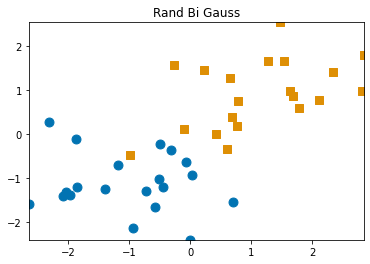

In [3]:
plt.title('Rand Bi Gauss')
plot_2d(bi_X, bi_Y)

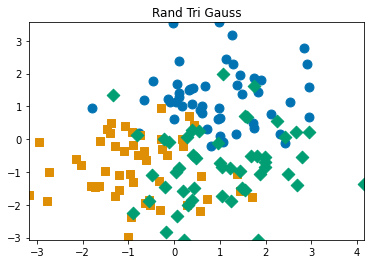

In [4]:
plt.title('Rand Tri Gauss')
plot_2d(tri_X, tri_Y)

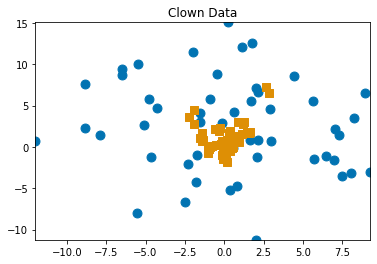

In [5]:
plt.title('Clown Data')
plot_2d(clown_X, clown_Y)

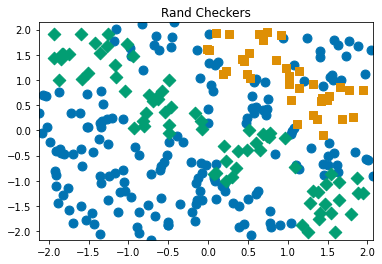

In [6]:
plt.title('Rand Checkers')
plot_2d(check_X, check_Y)

## <span style = "color: red"> Partie 2 : Approche intuitive

<span style = "color: green"> 3 - Version adaptée

Pour la régression, on peut par exemple affecter à x la valeur moyenne des k plus proches voisins.

## <span style = "color: red"> Partie 3 : Approche formelle

<span style = "color: green"> 4 - Knn Classifier

In [7]:
#################################
### Création de test et train ###
#################################
def tri_paire(X, Y):
    X_train = []
    X_test = []
    Y_train = []
    Y_test = []

    k = 0
    for x,y in zip(X,Y):
        if k%2 == 0:
            X_train.append(x)
            Y_train.append(y)

        else:
            X_test.append(x)
            Y_test.append(y)
            
        k+=1
    
    X_train = [l.tolist() for l in X_train]
    X_test = [l.tolist() for l in X_test]
    
    return np.array(X_train), np.array(Y_train), np.array(X_test), np.array(Y_test)



In [8]:
X_train, Y_train, X_test, Y_test = tri_paire(bi_X, bi_Y)

In [9]:
class KNNClassifier(BaseEstimator, ClassifierMixin):
    """ Homemade kNN classifier class """
    
    def __init__(self, n_neighbors=3):
        # Initialise la classe avec la valeur du neighbors
        self.n_neighbors = n_neighbors
    
    def fit(self, X, y):
        # Elle initialise la base de test du classifier
        self.X_ = X 
        # Les label
        self.y_ = y
        return self
    
    def predict(self, X):
        # Calcul de la distance euclidienne entre X et self.X_
        dist = sklearn.metrics.pairwise_distances(X, Y=self.X_, metric='euclidean', n_jobs = None)
        # Avec argsort nous trions les index de tel sorte que nous savons à qu'elle emplacement (indice) est à la plus petite valeur.
        index_sortie = np.argsort(dist)

        # Maintenant nous allons recuperer les n-voisins les plus proches de notre sortie 
        # grace à la distance euclidienne calculer et l'index des sortie.
        idx_neighbors = index_sortie[:, :self.n_neighbors]

        label_neighbors = self.y_[idx_neighbors]

        l = []

        for i in label_neighbors:
            ctr = Counter(i)
            label, common = ctr.most_common(1)[0]
            l.append(label)
        
        return l

In [10]:
m = KNNClassifier()

Test avec toutes les valeurs de X

In [11]:
m.fit(bi_X, bi_Y)

KNNClassifier()

In [12]:
a = m.predict(bi_X)

In [13]:
(a == bi_Y).mean()

0.975

Test avec comme train uniquement les emplacement pair

In [14]:
m2 = KNNClassifier()

In [15]:
m2.fit(X_train, Y_train)
a = m2.predict(X_test)
(a == Y_test).mean()

0.95

<span style = "color: green"> 5 - Use SKlearn and frontiere_new

In [16]:
def knn_sk(X_train, Y_train, X ,Y , n_neighb):
    knn = KNeighborsClassifier(n_neighb)

    knn.fit(X_train,Y_train)

    def f(pt):
        return knn.predict(pt.reshape(1, -1))

    frontiere_new(f, X,Y, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)

- CAS POUR TOUS LE JEU DE DONNEE

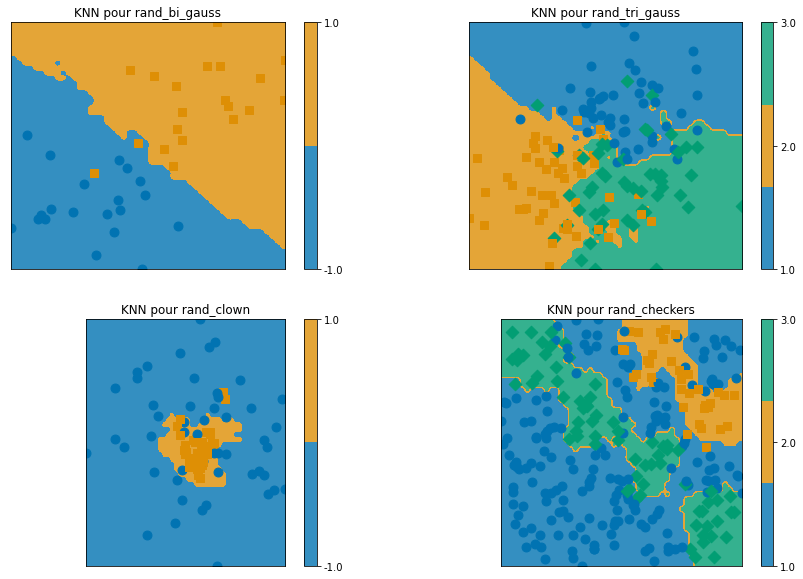

In [17]:
fig, ax = plt.subplots(1,4, figsize= (15,10))

plt.subplot(221, title= 'KNN pour rand_bi_gauss')
knn_sk(X_train = bi_X, Y_train=bi_Y, X = bi_X, Y = bi_Y, n_neighb = 5)

plt.subplot(222, title = 'KNN pour rand_tri_gauss')
knn_sk(X_train = tri_X, Y_train = tri_Y, X = tri_X, Y = tri_Y, n_neighb = 5)

plt.subplot(223, title = 'KNN pour rand_clown')
knn_sk(X_train = clown_X, Y_train = clown_Y, X = clown_X, Y = clown_Y, n_neighb = 5)

plt.subplot(224, title = 'KNN pour rand_checkers')
knn_sk(X_train = check_X, Y_train = check_Y, X = check_X, Y = check_Y, n_neighb = 5)



- CAS JEUX DES INDICES PAIR

In [18]:
X_train_bi, Y_train_bi, X_test_bi, Y_test_bi = tri_paire(bi_X, bi_Y)
X_train_tri, Y_train_tri, X_test_tri, Y_test_tri = tri_paire(tri_X, tri_Y)
X_train_clown, Y_train_clown, X_test_clown, Y_test_clown = tri_paire(clown_X, clown_Y)
X_train_check, Y_train_check, X_test_check, Y_test_check = tri_paire(check_X, check_Y)

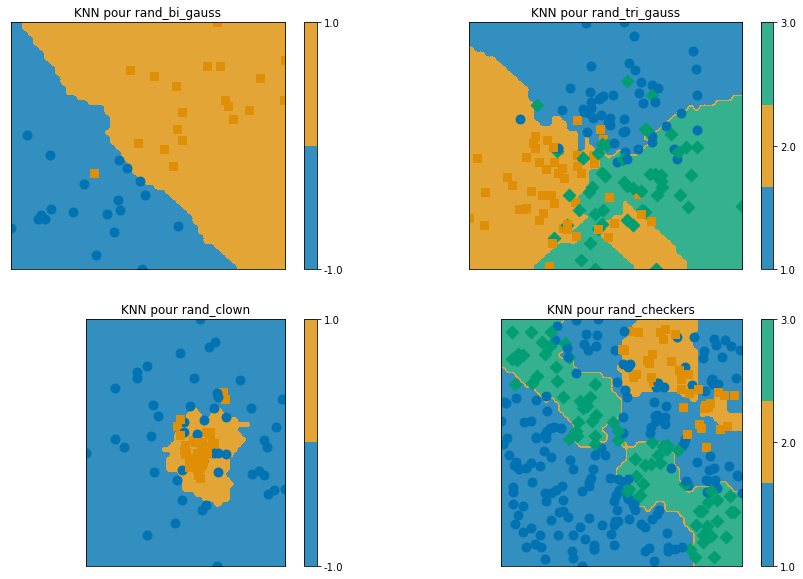

In [19]:
fig, ax = plt.subplots(1,4, figsize= (15,10))

plt.subplot(221, title= 'KNN pour rand_bi_gauss')
knn_sk(X_train = X_train_bi, Y_train=Y_train_bi, X = bi_X, Y = bi_Y, n_neighb = 5)

plt.subplot(222, title = 'KNN pour rand_tri_gauss')
knn_sk(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, n_neighb = 5)

plt.subplot(223, title = 'KNN pour rand_clown')
knn_sk(X_train = X_train_clown, Y_train = Y_train_clown, X = clown_X, Y = clown_Y, n_neighb = 5)

plt.subplot(224, title = 'KNN pour rand_checkers')
knn_sk(X_train = X_train_check, Y_train = Y_train_check, X = check_X, Y = check_Y, n_neighb = 5)



<span style = "color: green"> 6 - Faire varier k

- CAS POUR TOUS LE JEU DE DONNEE

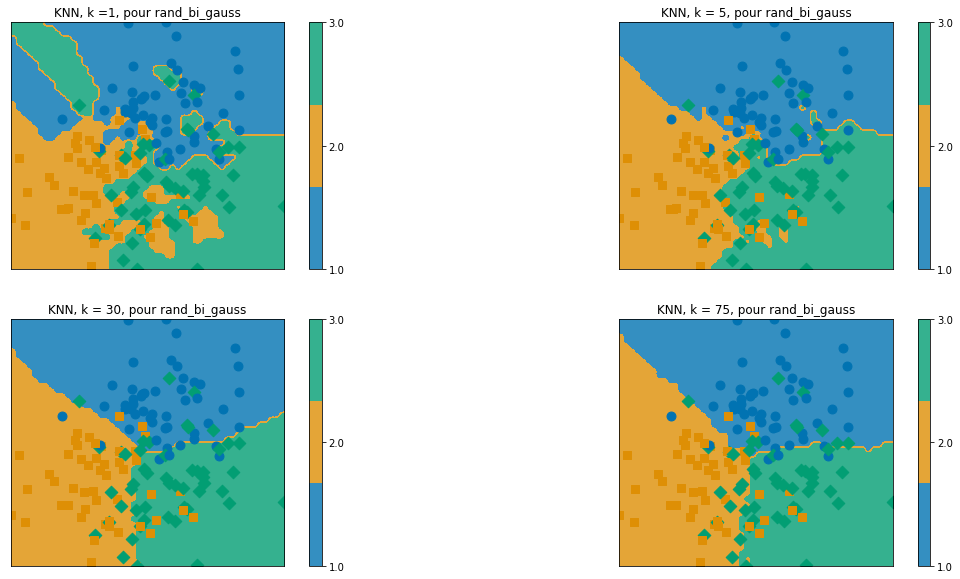

In [20]:
fig, ax = plt.subplots(1,4, figsize= (20,10))

plt.subplot(221, title= 'KNN, k =1, pour rand_bi_gauss')
knn_sk(X_train = tri_X, Y_train = tri_Y, X = tri_X, Y = tri_Y, n_neighb = 1)

plt.subplot(222, title = 'KNN, k = 5, pour rand_bi_gauss')
knn_sk(X_train = tri_X, Y_train = tri_Y, X = tri_X, Y = tri_Y, n_neighb = 5)

plt.subplot(223, title = 'KNN, k = 30, pour rand_bi_gauss')
knn_sk(X_train = tri_X, Y_train = tri_Y, X = tri_X, Y = tri_Y, n_neighb = 30)

plt.subplot(224, title = 'KNN, k = 75, pour rand_bi_gauss')
knn_sk(X_train = tri_X, Y_train = tri_Y, X = tri_X, Y = tri_Y, n_neighb = 75)

- CAS TRAIN SUR INDICE PAIR

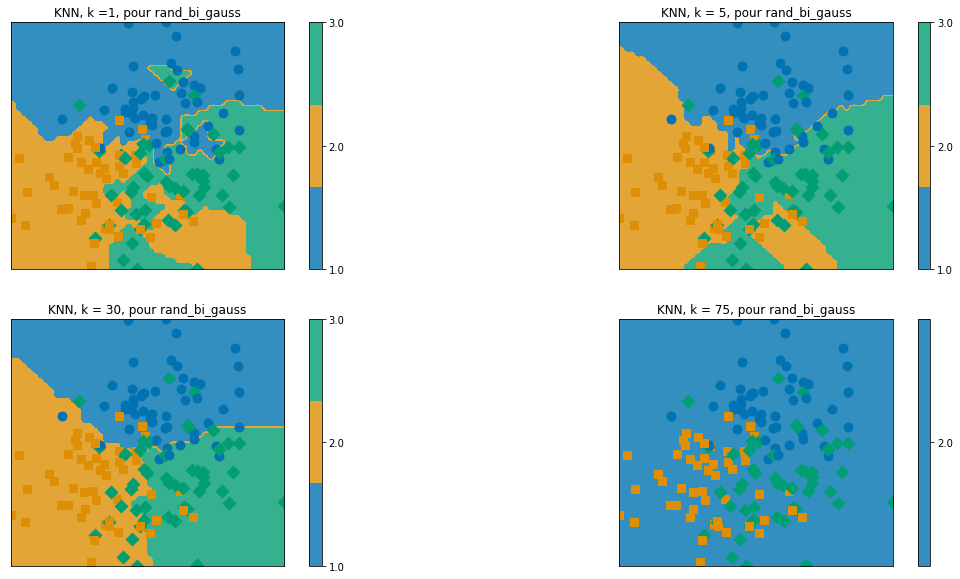

In [21]:
fig, ax = plt.subplots(1,4, figsize= (20,10))

plt.subplot(221, title= 'KNN, k =1, pour rand_bi_gauss')
knn_sk(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, n_neighb = 1)

plt.subplot(222, title = 'KNN, k = 5, pour rand_bi_gauss')
knn_sk(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, n_neighb = 5)

plt.subplot(223, title = 'KNN, k = 30, pour rand_bi_gauss')
knn_sk(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, n_neighb = 30)

plt.subplot(224, title = 'KNN, k = 75, pour rand_bi_gauss')
knn_sk(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, n_neighb = 75)

<span style = "color: green"> 7 - Paramètre weights au constructeur de KNeighborsClassifier.

In [22]:
def w_knn(X_train, Y_train, X, Y, j):
    def weight(distance):
        return np.exp(-distance**2 / 10**j)

    n_neighb = 7
    weight_knn = KNeighborsClassifier(n_neighb, p=2, weights = weight)

    weight_knn.fit(X_train, Y_train)

    def f(pt):
            return weight_knn.predict(pt.reshape(1, -1))

    frontiere_new(f, X,Y, w=None, step=50, alpha_choice=1, colorbar=True, samples=True)


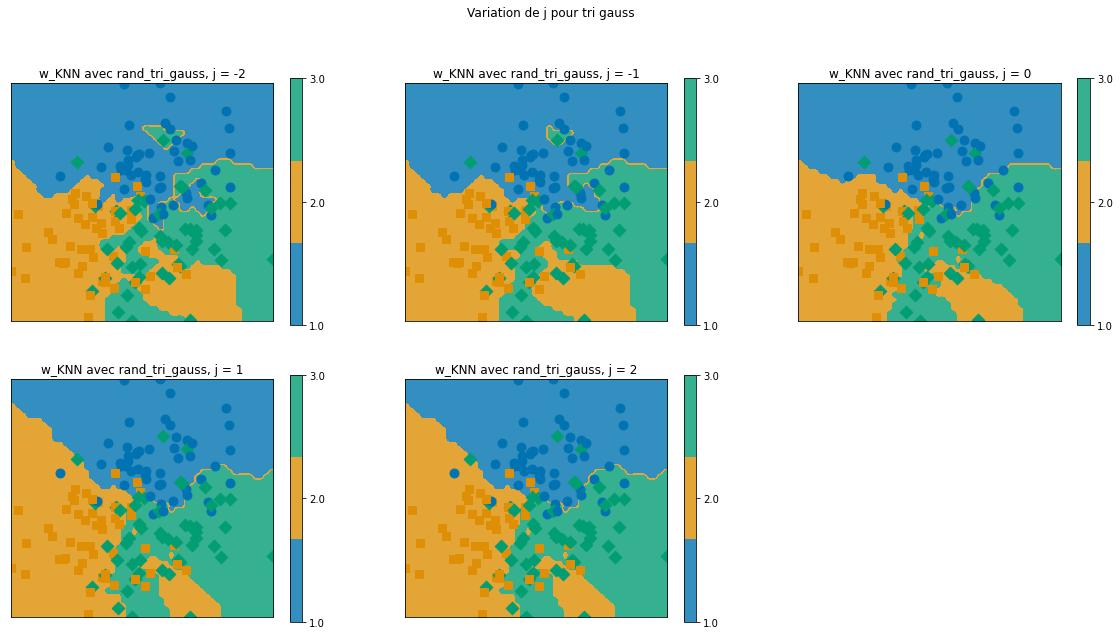

In [23]:
fig, ax = plt.subplots(1,5, figsize= (20,10))
plt.suptitle("Variation de j pour tri gauss")

plt.subplot(231, title= 'w_KNN avec rand_tri_gauss, j = -2')
w_knn(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, j = -2 )

plt.subplot(232, title = 'w_KNN avec rand_tri_gauss, j = -1')
w_knn(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, j = -1)

plt.subplot(233, title = 'w_KNN avec rand_tri_gauss, j = 0')
w_knn(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, j = 0)

plt.subplot(234, title = 'w_KNN avec rand_tri_gauss, j = 1')
w_knn(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, j = 1)

plt.subplot(235, title = 'w_KNN avec rand_tri_gauss, j = 2')
w_knn(X_train = X_train_tri, Y_train = Y_train_tri, X = tri_X, Y = tri_Y, j = 2)

- $j<0$ on accorde beaucoup plus d'importance aux points à une distance plus faible. On peut d'ailleurs le voir sur les plot.
- $j = -2$, il y a, comme pour un k faible, des "troues" dans les frontières qui devraient pourtant être bien séparé.
- avec des $j > 0$ la frontière devient de plus en plus lisse.

Plus j augmente moins il y a de suraprentissage.



<span style = "color: green"> 8 - Paramètre weights au constructeur de KNeighborsClassifier.

In [24]:
m3 = KNeighborsClassifier(3)
m3.fit(X_train_tri, Y_train_tri)

KNeighborsClassifier(n_neighbors=3)

In [25]:
print(m3.score(X_test_tri, Y_test_tri))

0.6666666666666666


Pour obtenir le taux d'erreur nous faison 1 - m3.score(X_test_tri, Y_test_tri).

In [26]:
print(1 - m3.score(X_test_tri, Y_test_tri))

0.33333333333333337


<span style = "color: green"> 9 - Tracez le taux d’erreur en fonction de k.

In [27]:
k_range = np.arange(1, 50)

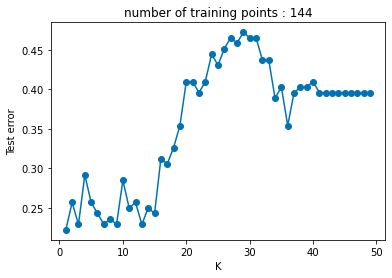

In [28]:
e = ErrorCurve(k_range = k_range)
 
e.fit_curve(X = X_train_check, y = Y_train_check, Xtest = X_test_check, ytest = Y_test_check)
e.plot()

<span style = "color: green"> 10 - Pour des nombres d’échantillons d’entrainement n prenant les valeurs 100, 200, 500 à 1000.

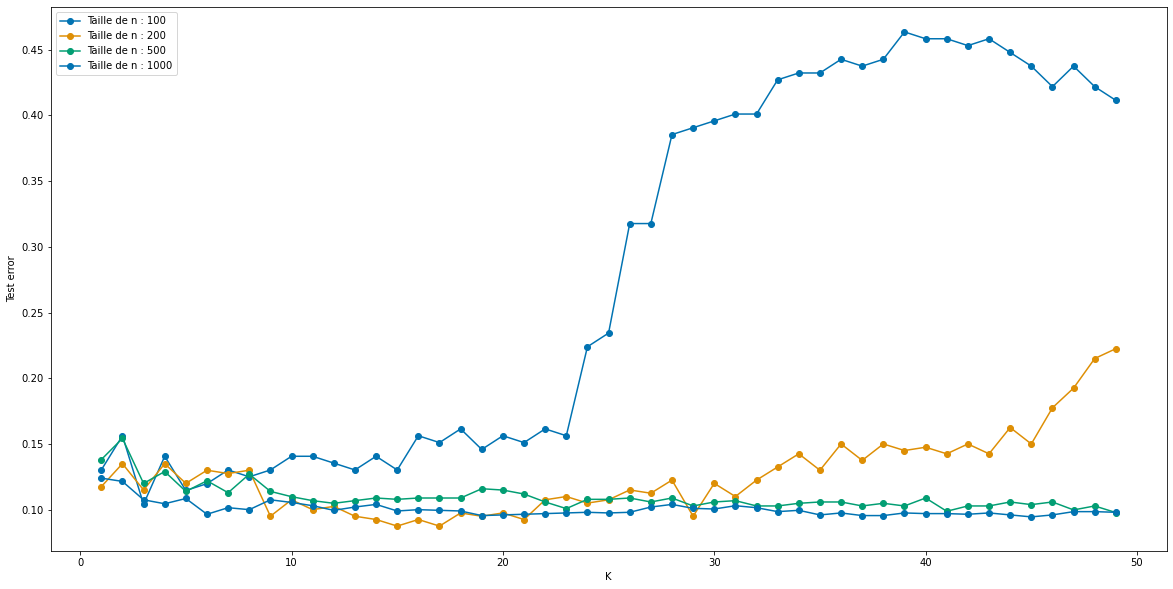

In [29]:
sigma = 0.1
valeurs_n = [100, 200, 500, 1000]

plt.figure(figsize=(20,10))
for n in valeurs_n:
    n1 = n2 = n
    Xtrain, Ytrain = rand_checkers(n1=n, n2=n, sigma = sigma)
    Xtest, Ytest = rand_checkers(n1=n, n2=n, sigma = sigma)
    e.fit_curve(X = Xtrain, y = Ytrain, Xtest = Xtest, ytest = Ytest)
    e.plot(maketitle = False)

plt.legend([("Taille de n : {}".format(n)) for n in valeurs_n], loc='upper left')

<span style = "color: green"> 11 - Avantage / Inconvenient 

**Inconvénient** : Une technique coûteuse en temps de calcul car il faut calculer la distance entre tous les points. De plus dans les tres hautes dimensions la notions de distance perd en pertinence.

**Avantage** : Il s'agit d'une méthode trés comprehensible et intuitive. Elle est donc trés interprétable.

<span style = "color: green"> 12 - Étudiez la base digits de scikit-learn.

In [30]:
chiffre = datasets.load_digits()

In [31]:
type(chiffre)


sklearn.utils.Bunch

In [32]:
chiffre.keys()

# Chiffre est un dictionnaire

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])

In [33]:
chiffre['data'].shape
# Data contient l'ensemble des images de taille 64 Pixel plus ou moins noir ou blanc

(1797, 64)

In [34]:
chiffre['target'].shape
# Target est l'ensemble des labels associés à chaque images. Il y a 1797 images donc 1797 labels associés.

(1797,)

In [35]:
chiffre['target_names'].shape
# Target_name la liste de l'ensemble des valeurs que peut prendre target. Càd 10 valeurs [0, 9]

(10,)

In [36]:
chiffre['images'].shape
# La même fonction que Data (stocker l'image) seul le format des images changent 
# avant nous avions des images de taille 64 maintenant les taille sont de 8x8

(1797, 8, 8)

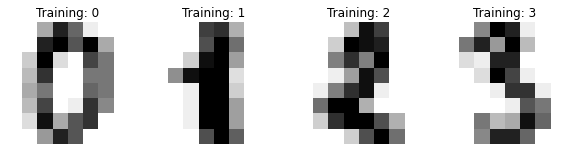

In [37]:
_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, chiffre.images, chiffre.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

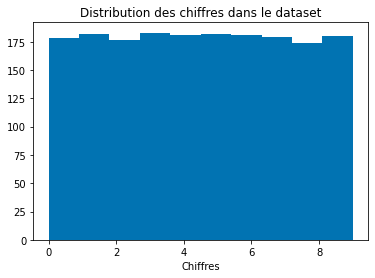

In [38]:
plt.hist(chiffre['target'])
plt.xlabel('Chiffres')
plt.title('Distribution des chiffres dans le dataset')
plt.show()

On observe une distrbution globalement uniforme.

In [39]:
n_samples = len(chiffre.images)
data = chiffre.images.reshape((n_samples, -1))

# Split data into 50% train and 50% test subsets
X_train_chiffre, X_test_chiffre, y_train_chiffre, y_test_chiffre = train_test_split(
    data, chiffre['target'], test_size=0.5, shuffle=False
)

In [40]:
mod = KNeighborsClassifier(n_neighbors=30)

mod.fit(X_train_chiffre, y_train_chiffre)

print("Le taux d'erreur d'un KNN avec k = 30 sur la base de données digits est de : ", 1 - mod.score(X_test_chiffre, y_test_chiffre))

Le taux d'erreur d'un KNN avec k = 30 sur la base de données digits est de :  0.07452725250278092


<span style = "color: green"> 13 - Matrice de confusion

In [41]:
predict_label = mod.predict(X_test_chiffre)
cm = confusion_matrix(y_test_chiffre, predict_label, labels=chiffre["target_names"])
cm

array([[87,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0, 82,  5,  1,  0,  1,  0,  0,  0,  2],
       [ 1,  0, 79,  6,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 81,  0,  3,  0,  4,  1,  2],
       [ 2,  0,  0,  0, 87,  0,  0,  2,  1,  0],
       [ 0,  0,  0,  0,  0, 85,  3,  0,  0,  3],
       [ 0,  0,  0,  0,  0,  0, 91,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 88,  0,  0],
       [ 0,  6,  1,  6,  0,  4,  1,  1, 68,  1],
       [ 1,  0,  0,  4,  0,  2,  0,  0,  1, 84]])

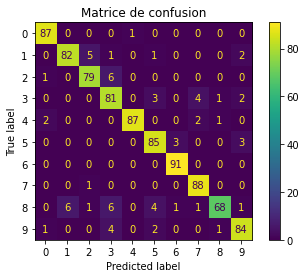

In [42]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=chiffre["target_names"])
disp.plot()
plt.title('Matrice de confusion')
plt.show()

<span style = "color: green"> 14 - Méthode pour trouver K

L'énoncé nous invite à utilise la fonction LOOCurve. 

On propose de procéder par cross-validation d'un contre tous. Il s'agit d'un cas particulier de la cross-validation à k blocs ou k = n. L'apprentissage se fait içi sur les n-1 blocs et la validation sur l'unique bloc restant.




In [43]:
k = [1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 100, 200]
LOOC = LOOCurve(k_range = k)
LOOC.fit_curve(X = chiffre['data'], y = chiffre['target'])

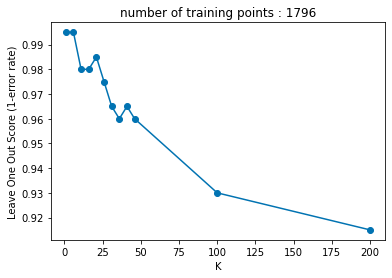

In [44]:
LOOC.plot()

## <span style = "color: red"> Partie 4 : Aspect théorique

<span style = "color: green"> 15 - En utilisant la formule de Bayes donner la formule des probabilités a posteriori.

Soit les valeurs suivantes :

$ P(X = x | Y = +1) = f_+ $

$ P(X = x | Y = -1) = f_-$

$ π_+ = P(Y = +1) $

$ π_- = P(Y = -1) $

$ π_+ + π_- = 1 $

On cherche à exmprimer $P(Y = +1 | X = x)$ en fonction de $π_+ , f_+ $ et $f_-$.



$P(Y = +1 | X = x) = \cfrac{P(Y = +1) P(X = x | Y = +1)}{P(Y = -1) P(X = x | Y = -1) + P(Y = +1) P(X = x | Y = +1)} $



$~~~~~~~~~~~~~~~~~~~~~~~~~~~~~= \cfrac{π_+ f_+}{(1 - π_+) f_- + π_+ f_+ } $


De même.

$P(Y = -1 | X = x) = \cfrac{(1 - π_+) f_-}{(1 - π_+) f_- + π_+ f_+} $

<span style = "color: green"> 16 - Exprimer le log-ratio des deux classes 

Soit : 

$log( \cfrac{ P(Y = +1 | X = x) }{P(Y = −1 | X = x )}) > 0 $


On remplace les valeurs avec nos réultats de la question précédente.

$log( \cfrac{\cfrac{π_+ f_+}{(1 - π_+) f_- + π_+ f_+ }}{\cfrac{(1 - π_+) f_-}{(1 - π_+) f_- + π_+ f_+}}) > 0$

d'ou :

$log \Bigg(\cfrac{π_+ f_+}{(1 - π_+) f_-}\Bigg) > 0$



Remplaçons $f_+$ et $f_-$ par leur expression :



$\large f_+ = \frac{1}{\sqrt{2*\pi}*\sqrt{det(\Sigma_t)}} * \exp(-\frac{1}{2}(x-\mu_+)^T\Sigma^{-1}(x-\mu_+))$



$\large f_- = \frac{1}{\sqrt{2*\pi}*\sqrt{det(\Sigma_t)}} * \exp(-\frac{1}{2}(x-\mu_-)^T\Sigma^{-1}(x-\mu_-))$

à partir de la on obtient l'expression suivante 

$$log\Bigg(~~~\cfrac{ P(Y = +1 | X = x) }{P(Y = −1 | X = x )}~~~\Bigg) = log\Bigg(~~~\cfrac{π_+}{1 - π_+}~~*~~\exp\Bigg(~~\cfrac{-1}{2} (x - µ_+)^T Σ^{-1} (x - µ_+) + \cfrac{1}{2} (x - µ_-)^T Σ^{-1} (x - µ_-)~~\Bigg)~~~\Bigg) 

\\ 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ 
= \cfrac{-1}{2}\Bigg[(x - µ_+)^T Σ^{-1} (x - µ_+) - (x - µ_-)^T Σ^{-1} (x - µ_-)\Bigg] + log(\cfrac{π_+}{1 - π_+})$$



On dispose à présent d’un échantillon de ce mélange et on suppose que  ${\pi_+}$, $\mu_+$, $\mu_-$ et $\Sigma$ 
sont des paramètres inconnus. On suppose que l’échantillon considéré contient n observations notées
$(x_1; y_1); . . . ; (x_n; y_n)$ et que $\sum_{i=1}^{n}1[y_i = +1]$.
On va utiliser les estimateurs sans biais ${\pi_+}$, $\mu_+$, $\mu_-$ et $\Sigma$ des paramètres :

$$
\widehat\pi_+ = \frac{m}{n}_
~~~~;~~~~\widehat\mu_+=\frac{1}{m}\sum_{i=1}^{n}1[y_i=+1]x_i
~~~~;~~~~\widehat\mu_-\frac{1}{n-m}\sum_{i=1}^{n}1[y_i=-1]x_i
$$
et
$$
\widehat\Sigma=\frac{1}{n-2}((m-1)\widehat\Sigma_++(n-m-1)\widehat\Sigma_-)
$$
avec
$$
\widehat\Sigma_+=\frac{1}{m-1}\sum_{i=1}^{n}1[y_i=+1](x_i-\widehat\mu_+)(x_i-\widehat\mu_+)^T
~~~~;~~~~
\widehat\Sigma_-=\frac{1}{n-m-1}\sum_{i=1}^{n}1[y_i=-1](x_i-\widehat\mu_-)(x_i-\widehat\mu_-)^T
$$

<span style = "color: green"> 17 - Justifier le choix du classifieur 

La frontière correspond à l'ensemble des points de x tq :
$$
P(Y = +1 | X = x) = P(Y = −1 | X = x )
$$

Ainsi toute nouvelle observatio de x ayant le label + 1 (i.e Y=+1) doit vérifier à 

$$
P(Y = +1 | X = x) > P(Y = −1 | X = x )
$$
$$
\Leftrightarrow \frac{P(Y = +1 | X = x)}{P(Y = −1 | X = x )} > 1
$$
$$
\Leftrightarrow \log{\Bigg(\frac{P(Y = +1 | X = x)}{P(Y = −1 | X = x )}\Bigg)} > 0
$$


Nous avons vu, à la question récédente, que l'on peut écrire l'équation ci dessus de la manière suivante :


$$
\begin{aligned}

    &\cfrac{-1}{2}\Bigg[(x - µ_+)^T Σ^{-1} (x - µ_+) - (x - µ_-)^T Σ^{-1} (x - µ_-)\Bigg] + log(\cfrac{π_+}{1 - π_+})>0 
    
    \\
    
    &\Leftrightarrow\widehat x^t * \widehat\Sigma^{-1}(~\widehat\mu_+-~\widehat\mu_-)-\frac{1}{2}~\widehat\mu_+^T~\widehat\Sigma^{-1}~\widehat\mu_++\frac{1}{2}~\widehat\mu_-^T~\widehat\Sigma^{-1}~\widehat\mu_-+\log(\frac{\pi_+}{1-\pi_+})>0

    \\

    &\Leftrightarrow x^t * \widehat\Sigma^{-1}(~\widehat\mu_+-~\widehat\mu_-) > \frac{1}{2}~[\widehat\mu_+^T~\widehat\Sigma^{-1}~\widehat\mu_+-~\widehat\mu_-^T~\widehat\Sigma^{-1}~\widehat\mu_-]-\log(\frac{\pi_+}{1-\pi_+})

    \\

    &\Leftrightarrow x^t * \widehat\Sigma^{-1}(~\widehat\mu_+-~\widehat\mu_-) > \frac{1}{2}~[\widehat\mu_+^T~\widehat\Sigma^{-1}~\widehat\mu_+-~\widehat\mu_-^T~\widehat\Sigma^{-1}~\widehat\mu_-]-log(\pi_+)-log(1-\pi_+)

\end{aligned}
$$


or $\pi_+=\frac{m}{n}$


Ainsi on a bien le classifieur :

\begin{Bmatrix} 1& si & x^T \hat{\Sigma}^{-1}(\hat{\mu}{+} - \hat{\mu}{-}) > (\hat{\mu}^T{-} \hat{\Sigma}^{-1}\hat{\mu}^T{-}) - log({\frac mn}) - log({1-\frac mn})\\ -1 & sinon \end{Bmatrix}



## <span style = "color: red"> Partie 5 : Mise en oeuvre

<span style = "color: green"> 18 - Ecrire la classe LDAClassifier 

In [45]:
class LDAClassifier():

    def fit(self, X, y):

        m = np.sum(y[y==1])
        n = y.shape[0]
        pi_plus = m/n
        
        mu_plus = 1/m * np.sum(X[np.where(y==1),:][0], axis = 0)
        mu_minus = 1/(n-m) * np.sum(X[np.where(y==-1),:][0], axis = 0)

        sigma_plus = 1/(m-1) * ((X[np.where(y==1), :][0] - mu_plus).T @ (X[np.where(y==1), :][0] - mu_plus))
        sigma_minus = 1/(n-m-1) * ((X[np.where(y==-1), :][0] - mu_minus).T @ (X[np.where(y==-1), :][0] - mu_minus))

        sigma = (1 / (n - 2)) * (  (m-1)*sigma_plus + (n-m-1)*sigma_minus  )
        
        sigma_inv = inv(sigma)
        
        # On implémente l'inégalité que nous avons trouvez question 17

        g1 = mu_plus.T @ sigma_inv @ mu_plus
        g2 = mu_minus.T @ sigma_inv @ mu_minus

        A = 1/2 * (g1 - g2) - np.log(pi_plus) - np.log(1 - pi_plus)

        self.mu_plus = mu_plus
        self.mu_minus = mu_minus
        self.test = A
        self.sigma_inv = sigma_inv
        
        return self
    
    def predict(self, X):

        y_pred = X @ self.sigma_inv @ (self.mu_plus - self.mu_minus)
        y_pred[y_pred > 0] = 1
        y_pred[y_pred <= 0] = -1

        return y_pred

    def score(self, y_prediction, y_origine):
        return (y_prediction == y_origine).mean()


In [46]:
X_18, y_18 = rand_bi_gauss(n1= 50, n2 = 50, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.7,0.7], sigmas2=[0.7, 0.7])


In [47]:
my_mod = LDAClassifier()

In [48]:
my_mod.fit(X_18, y_18)

In [49]:
y_pred = my_mod.predict(X_18)

my_mod.score(y_pred, y_18)

0.99

<span style = "color: green"> 19 - Avec SKLearn vs notre modèle

- SKLearn model

In [50]:
X_19, y_19 = rand_bi_gauss(n1= 500, n2 = 50, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.7,0.7], sigmas2=[0.7, 0.7])

X_19_train, X_19_test, y_19_train, y_19_test = train_test_split(X_19, y_19, test_size=0.8, shuffle=True)

LDA = LinearDiscriminantAnalysis()

model_sk_LDA = LDA.fit(X_19_train, y_19_train)

predict_sk_LDA = model_sk_LDA.predict(X_19_test)


In [51]:
(predict_sk_LDA == y_19_test).mean()

0.9840909090909091

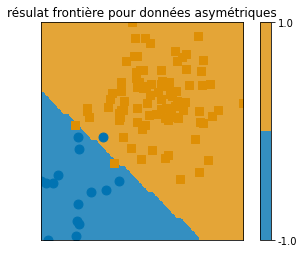

In [52]:
def front(fc):
    return model_sk_LDA.predict(fc.reshape(1,-1))

frontiere_new(front,  X_19_train, y_19_train)
plt.title('résulat frontière pour données asymétriques')
plt.show()

Malgré l'asymétrie des classes l'algorythme semble avoir trouvé une règle satisfaisante.

- Notre modèle

In [53]:
my_model = LDAClassifier().fit(X_19_train, y_19_train)

y_pred = my_model.predict(X_19_test)

In [54]:
("La valeur prédite par mon modèle est = ",my_model.score(y_pred, y_19_test))

('La valeur prédite par mon modèle est = ', 0.9727272727272728)

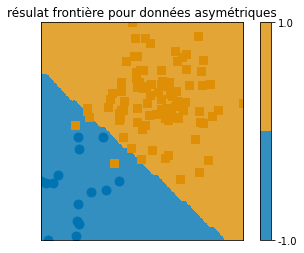

In [55]:
def front(fc):
    return my_model.predict(fc.reshape(1,-1))

frontiere_new(front,  X_19_train, y_19_train)
plt.title('résulat frontière pour données asymétriques')
plt.show()

<span style = "color: green"> 20 - Visualisez la règle de classification pour les jeux de données
#1 et #3.

In [56]:
X_bi_20, y_bi_20 = rand_bi_gauss(n1= 1000, n2 = 500, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.7,0.7], sigmas2=[0.7, 0.7])

X_clown_20, y_clown_20 = rand_clown(n1= 100, n2 = 50, sigma1=1, sigma2= 2)

- Mod pour rand bi gauss 

In [57]:
X_20_bi_train, X_20_bi_test, y_20_bi_train, y_20_bi_test = train_test_split(X_bi_20, y_bi_20, test_size=0.8, shuffle=True)

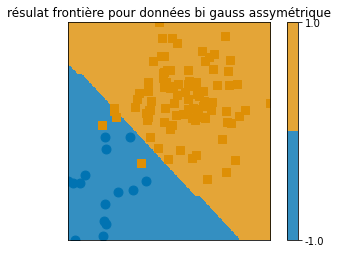

In [58]:
model_bi = LDAClassifier().fit(X_20_bi_train, y_20_bi_train)

pred_bi = model_bi.predict(X_20_bi_test)

("La valeur prédite par mon modèle est = ",model_bi.score(pred_bi, y_20_bi_test))


def front(fc):
    return model_bi.predict(fc.reshape(1,-1))

frontiere_new(front,  X_19_train, y_19_train)
plt.title('résulat frontière pour données bi gauss assymétrique')
plt.show()

- Mod pour rand clown 

In [59]:
X_20_clown_train, X_20_clown_test, y_20_clown_train, y_20_clown_test = train_test_split(X_clown_20, y_clown_20, test_size=0.8, shuffle=True)

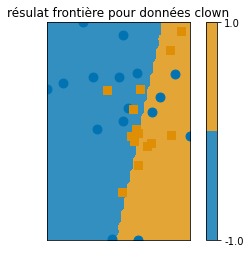

In [60]:
model_clown = LDAClassifier().fit(X_20_clown_train, y_20_clown_train)

pred_bi = model_clown.predict(X_20_clown_test)

("La valeur prédite par mon modèle est = ",model_clown.score(pred_bi, y_20_clown_test))


def front(fc):
    return model_clown.predict(fc.reshape(1,-1))

frontiere_new(front,  X_20_clown_train, y_20_clown_train)
plt.title('résulat frontière pour données clown')
plt.show()

Le résulat sur #1 est plutôt bon. La frontière des données est trés linéaire.

Pour le #3 le résultat est beaucoup moins perfomant. Il n'existe pas réellement de frontière linéaire entre les jeux de données. Les données sont plus proche de forme quadratique.  

## <span style = "color: red"> Partie 6 : Méthode discriminative avec régression logistique

<span style = "color: green"> 21 - Appliquez la classification par régression logistique sur les données rand_bi_gauss. Comparer les
résultats avec la LDA.


In [61]:
X, y = rand_bi_gauss(n1= 800, n2 = 200, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.8,0.8], sigmas2=[0.8, 0.8])

X_unbalanced_train, X_unbalanced_test, y_unbalanced_train, y_unbalanced_test = train_test_split(X, y, test_size=0.8, shuffle=True)



In [62]:
# Cas linear model

m_lm = linear_model.LogisticRegression()

m_lm = m_lm.fit(X_unbalanced_train, y_unbalanced_train)

score_lm = m_lm.score(X_unbalanced_test, y_unbalanced_test)

print("Le score du model lm est :", score_lm)

Le score du model lm est : 0.96375


In [63]:
# Cas LDA

m_LDA = LinearDiscriminantAnalysis().fit(X_unbalanced_train, y_unbalanced_train)

score_lda = m_LDA.score(X_unbalanced_test, y_unbalanced_test)

print("Le score du model lda est :", score_lda)


Le score du model lda est : 0.96625


In [64]:
liste_score_lda =[]
liste_score_lm = []

for i in range (100):
    X, y = rand_bi_gauss(n1= 800, n2 = 200, mu1=[1, 1], mu2=[-1, -1], sigmas1=[0.8,0.8], sigmas2=[0.8, 0.8])

    X_unbalanced_train, X_unbalanced_test, y_unbalanced_train, y_unbalanced_test = train_test_split(X, y, test_size=0.8, shuffle=True)

    m_lm = linear_model.LogisticRegression().fit(X_unbalanced_train, y_unbalanced_train)

    score_lm = m_lm.score(X_unbalanced_test, y_unbalanced_test)

    liste_score_lm.append(1 - score_lm)

    m_LDA = LinearDiscriminantAnalysis().fit(X_unbalanced_train, y_unbalanced_train)

    score_lda = m_LDA.score(X_unbalanced_test, y_unbalanced_test)

    liste_score_lda.append(1 - score_lda)

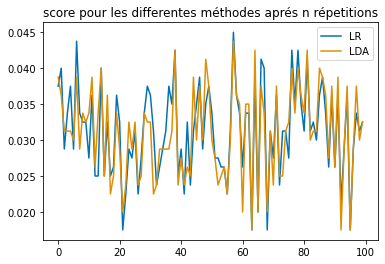

In [65]:
plt.plot(liste_score_lm, label='LR')
plt.plot(liste_score_lda, label='LDA')
plt.legend()
plt.title('score pour les differentes méthodes aprés n répetitions')
plt.show()

On observe que les deux méthodes ont des résultats trés similaires en termes de score.

<span style = "color: green"> 22 - À quoi correspond la variable coef_ du modèle ? intercept_ ?

- **coef_** correspond aux coefficients de chacunes des covariables dans le modèle de regression logistique.

- **intercept_** correspond au biais introduit. On peut aussi le voir comme l'ordonnée à l'origine de la regression.

In [66]:
m_lm.coef_

array([[2.00594028, 2.16807702]])

In [67]:
m_lm.intercept_

array([1.23456421])

<span style = "color: green"> 23 - Utiliser la fonction frontiere_new pour visualiser la frontière de décision

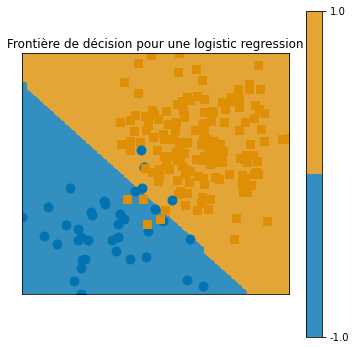

In [68]:
def front(x):
    return m_lm.predict(x.reshape(1,-1))

plt.figure(figsize=(6,6))
frontiere_new(front,  X_unbalanced_train, y_unbalanced_train, w=None, step=50, alpha_choice=1, colorbar=True,
                  samples=True)
plt.title('Frontière de décision pour une logistic regression')
plt.show()

<span style = "color: green"> 24 - Application sur digits

In [69]:
X_chiffre_train, X_chiffre_test, y_chiffre_train, y_chiffre_test = train_test_split(chiffre['data'], chiffre['target'], test_size=0.5, shuffle = True )

In [70]:
model_lr_chiffre = linear_model.LogisticRegression(max_iter=10000)
model_lr_chiffre.fit(X_chiffre_train, y_chiffre_train)

LogisticRegression(max_iter=10000)

In [71]:
score_chiffre = model_lr_chiffre.score(X_chiffre_test, y_chiffre_test)


In [72]:
print("Le résultat d'erreur du model pour digits est : ", 1 - score_chiffre)

Le résultat d'erreur du model pour digits est :  0.04004449388209119
